In [1]:
from tensorflow.keras.layers import Dense,Lambda,Flatten,Input

In [2]:
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D

In [3]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model, Sequential

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [5]:
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b

In [6]:
def VGG16_AvgPool(shape):
  vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)
  i= vgg.input
  x=i
  for layer in vgg.layers:
    if layer.__class__==MaxPooling2D:
      x=AveragePooling2D()(x)
    else:
      x=layer(x)
  return Model(i,x)


In [7]:
def VGG16_AvgPool_CutOff(shape, num_convs):
  if num_convs<1 or num_convs>13:
    print("must specify a number between 1 and 13")
    return None
  n=0
  model=VGG16_AvgPool(shape)
  for layer in model.layers:
    if layer.__class__==Conv2D:
      n+=1
    if n>=num_convs:
      output=layer.output
      break
  return Model(model.input,output)    

In [8]:
def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img


def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x

In [16]:
if __name__ == '__main__':
  path='/content/image_0002.jpg'
  img=image.load_img(path)
  img=image.img_to_array(img)
  x = np.expand_dims(img, axis=0)
  x = preprocess_input(x)
  batch_shape=x.shape
  x=preprocess_input(x)
  batch_shape = x.shape
  shape = x.shape[1:]
  content_model = VGG16_AvgPool_CutOff(shape, 10)
  target = K.variable(content_model.predict(x))
  loss= K.mean(K.square(target-content_model.output))
  grad= K.gradients(loss,content_model.input)
  get_loss_and_grads=K.function([content_model.input],[loss]+grad)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, 225, 300, 3), dtype=float32)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, 225, 300, 3), dtype=float32)


In [17]:
def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)

iter=0, loss=3616.822509765625
iter=1, loss=1661.0576171875
iter=2, loss=1037.83740234375
iter=3, loss=793.2539672851562
iter=4, loss=624.8938598632812
iter=5, loss=527.8373413085938
iter=6, loss=467.5655822753906
iter=7, loss=415.1994934082031
iter=8, loss=377.4345397949219
iter=9, loss=349.9682922363281


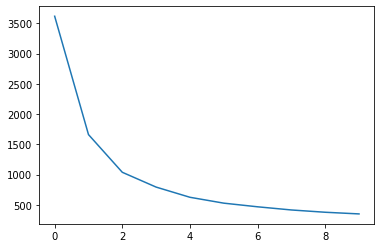

In [18]:
losses = []
x = np.random.randn(np.prod(batch_shape))
for i in range(10):
  x, l, _ = fmin_l_bfgs_b(
      func=get_loss_and_grads_wrapper,
      x0=x,
      maxfun=20
    )
  x = np.clip(x, -127, 127)
  print("iter=%s, loss=%s" % (i, l))
  losses.append(l)


plt.plot(losses)
plt.show()





In [19]:
newimg = x.reshape(*batch_shape)
final_img = unpreprocess(newimg)

In [10]:
import tensorflow as tf
if tf.__version__.startswith('2'):
  tf.compat.v1.disable_eager_execution()

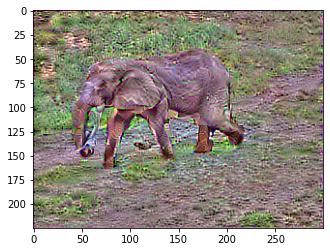

In [20]:
  plt.imshow(scale_img(final_img[0]))
  plt.show()


In [21]:
def gram_matrix(img):
  X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
  G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
  return G


def style_loss(y, t):
  return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

def minimize(fn, epochs, batch_shape):
  x = np.random.randn(np.prod(batch_shape))
  for i in range(epochs):
    x, l, _ = fmin_l_bfgs_b(
      func=fn,
      x0=x,
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

 
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)
  return final_img[0]


In [22]:
shape

(225, 300, 3)

In [23]:
stylepath='/content/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'

In [24]:
simg=image.load_img(path)

In [25]:
x=image.img_to_array(simg)

In [27]:
x = np.expand_dims(x, axis=0)

In [30]:
batch_shape = x.shape
shape = x.shape[1:]

In [31]:
svgg = VGG16_AvgPool(shape)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_3:0", shape=(None, 225, 300, 3), dtype=float32)


In [32]:
symbolic_conv_outputs = [
    layer.get_output_at(1) for layer in svgg.layers \
    if layer.name.endswith('conv1')
  ]

In [33]:
multi_output_model=Model(svgg.input,symbolic_conv_outputs)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_3:0", shape=(None, 225, 300, 3), dtype=float32)


In [34]:
style_layer_outputs=[K.variable(y) for y in multi_output_model.predict(x)]

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [35]:
loss = 0
for symbolic, actual in zip(symbolic_conv_outputs,style_layer_outputs):
    loss += style_loss(symbolic[0], actual[0])

In [36]:
grads = K.gradients(loss, multi_output_model.input)

In [37]:
get_loss_and_grads = K.function(
    inputs=[multi_output_model.input],
    outputs=[loss] + grads
)


def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

iter=0, loss=50451.00390625
iter=1, loss=2323.5556640625
iter=2, loss=209.59120178222656
iter=3, loss=138.63023376464844
iter=4, loss=120.36234283447266
iter=5, loss=122.27277374267578
iter=6, loss=112.4285888671875
iter=7, loss=115.30382537841797
iter=8, loss=111.83406829833984
iter=9, loss=109.20912170410156


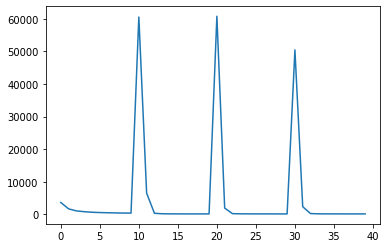

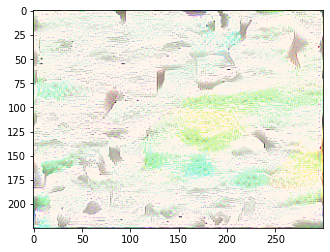

In [41]:
final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale_img(final_img))
plt.show()

In [42]:
def load_img_and_preprocess(path, shape=None):
  img = image.load_img(path, target_size=shape)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  return x

In [43]:
content_img = load_img_and_preprocess('/content/image_0002.jpg',(225,300))

In [44]:
content_img.shape

(1, 225, 300, 3)

In [45]:
h, w = content_img.shape[1:3]
style_img = load_img_and_preprocess('/content/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',(h, w))

In [46]:
shape

(225, 300, 3)

In [47]:
fvgg = VGG16_AvgPool(shape)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_4:0", shape=(None, 225, 300, 3), dtype=float32)


In [48]:
content_model = Model(fvgg.input, fvgg.layers[13].get_output_at(1))
content_target = K.variable(content_model.predict(content_img))

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_4:0", shape=(None, 225, 300, 3), dtype=float32)
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [49]:
symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in fvgg.layers \
  if layer.name.endswith('conv1')
]

In [50]:
style_model = Model(fvgg.input, symbolic_conv_outputs)
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]
style_weights = [0.2,0.4,0.3,0.5,0.2]

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_4:0", shape=(None, 225, 300, 3), dtype=float32)


In [51]:
loss = K.mean(K.square(content_model.output - content_target))

In [52]:
for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
  loss += w * style_loss(symbolic[0], actual[0])

In [53]:
grads = K.gradients(loss,fvgg.input)
get_loss_and_grads = K.function(
  inputs=[fvgg.input],
  outputs=[loss] + grads
)


def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)

iter=0, loss=2006.3385009765625
iter=1, loss=391.4320983886719
iter=2, loss=249.12399291992188
iter=3, loss=199.3568572998047
iter=4, loss=172.78761291503906
iter=5, loss=157.15402221679688
iter=6, loss=145.73573303222656
iter=7, loss=136.7855682373047
iter=8, loss=129.03114318847656
iter=9, loss=123.5788803100586


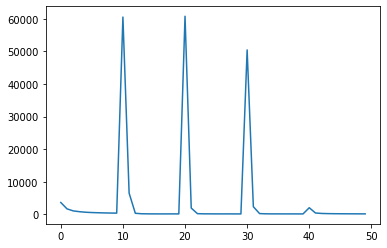

In [54]:
final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)

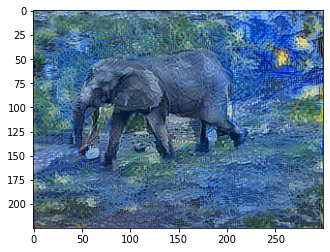

In [59]:
plt.imshow(scale_img(final_img))
plt.show()